```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](https://github.com/vlvovch/PHYS6350-ComputationalPhysics/blob/spring2025/slides/Lecture18-04-01-25-RandomNumbers-2.pdf)
```

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Compute integral \int_a^b f(x) dx as an average of f(x) over the interval (a,b)
# Returns the value of the integral and the error estimate
def intMC(f, N, a, b):
    total = 0
    total_sq = 0
    for i in range(N):
        x = a + (b-a)*np.random.rand()
        fval = f(x)
        total += fval
        total_sq += fval * fval
    f_av = total / N
    fsq_av = total_sq / N 
    return (b-a) * f_av, (b-a) * np.sqrt((fsq_av - f_av*f_av)/N)

# Nonuniform random numbers

In many cases we deal with random numbers $\xi$ that are distributed non-uniformly.
Common examples are:
- Exponential distribution $\rho(x) = e^{-x}$.
- Gaussian distribution $\rho(x) \propto e^{-\frac{x^2}{2\sigma^2}}$.
- Power-law distribution $\rho(x) \propto x^{\alpha}$.
- Arbitrary peaked distributions.

There are two common methods for generating nonunifrom random variates.
They both make use of uniformly distributed variates.

## Inverse transform sampling

```{figure} invtr.png
:width: 300px
:align: center
:name: fig-invtr
```

<!-- ![invtr](invtr.png) -->

The basic idea is that if $\eta$ is a uniformly distibuted random variable, some function of it, $\xi = f(\eta)$, is not. The idea is to sample $\eta$ and calculate $\xi$ via this function such that $\xi$ corresponds to a desired probability density $\rho(\xi)$. How to find the function $f(\eta)$?

Without the loss of generality assume that $\xi \in (-\infty, \infty)$ and that $f(\eta)$ maps $\eta$ to $\xi$ such that $f(0) \to -\infty$. Consider now the cumulative distribution function 

$$
G(x) = Pr(\xi < x) = \int_{-\infty}^x \rho(\xi) d\xi.
$$ 

It corresponds to the probability that $\eta < y$ where $y$ is such that $x = f(y)$. Since $\eta$ is uniformly distributed, this probablity equals to $y$. Therefore,

$$
G[x = f(y)] = y,
$$

thus

$$
f(y) = G^{-1}(y).
$$

If we can calculate the inverse of $G^{-1}(y)$ of the cumulative distribution function for $\xi$, we are good.

The algorithm is the following:
1. Calculate the cumulative distribution

$$
G(x) = \int_{-\infty}^x \rho(\xi) d\xi
$$

2. Find the inverse function $G^{-1}(y)$ as the solution to the equation

$$
G(x) = y
$$

with respect to $x$.

3. Sample uniformly distributed randon variables $\eta$ and calculate $\xi = G^{-1}(\eta)$

Sometimes, evaluating $G(x)$ and/or $G^{-1}(y)$ explicitly is challenging.
In such cases one would resort to numerical integration and/or non-linear equation solvers.

### Sampling the exponential distribution

Recall the radioactive decay process. The time of decay is distributed in accordance with

$$
\rho(t) = \frac{1}{\tau} e^{-\frac{t}{\tau}}.
$$

The cumulative distibution function reads

$$
F(x) = \int_0^{x} \frac{1}{\tau} e^{-\frac{t}{\tau}} dt = 1 - e^{-\frac{x}{\tau}}.
$$

To apply inverse transform sampling we have to invert $F(x)$ by solving the equation

$$
1 - e^{-\frac{t}{\tau}} = \eta.
$$

This can be done straightforwardly to give

$$
t(\eta) = -\tau \ln(1-\eta).
$$

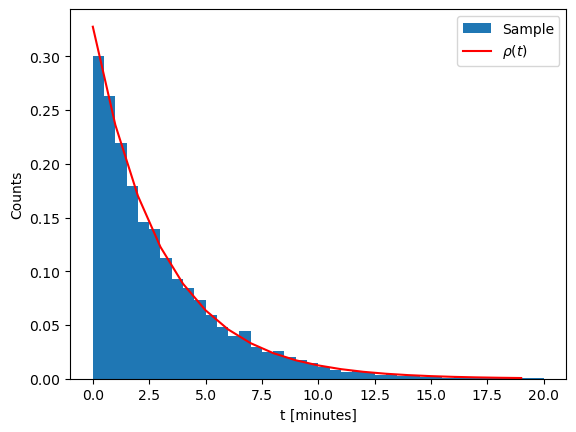

In [3]:
## Radioactive decay sampler
def sample_tdecay(tau):
    eta = np.random.rand()
    return -tau * np.log(1-eta)
    

tau = 3.053 # Half-time in minutes
N = 10000   # Number of samples
tdecays = [sample_tdecay(tau) for i in range(N)]

# Show a histogram
plt.xlabel("t [minutes]")
plt.ylabel("Counts")
plt.hist(tdecays, bins = 40, range=(0,20), density=True, label = 'Sample')
# Show true distribution
plt.plot([x for x in np.arange(0,20)], [1/tau * np.exp(-t/tau) for t in np.arange(0,20)], color='r', label='${\\rho(t)}$')
plt.legend()
plt.show() 

### Sampling the points inside a circle

Let us sample points on a plane inside a unit circle.
One way to do that is to switch to polar coordinates

$$
x = r \cos(\phi), \qquad y = r \sin(\phi),
$$

and sample $r$ and $\phi$.

Since $r \in [0,1)$ and $\phi \in [0,2\pi)$,
naively one could sample $r$ and $\phi$ independently from two uniform distributions.
Let us see what happens

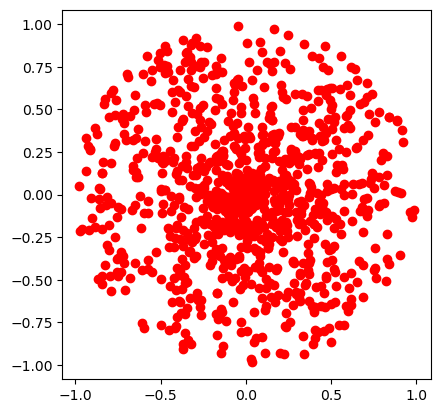

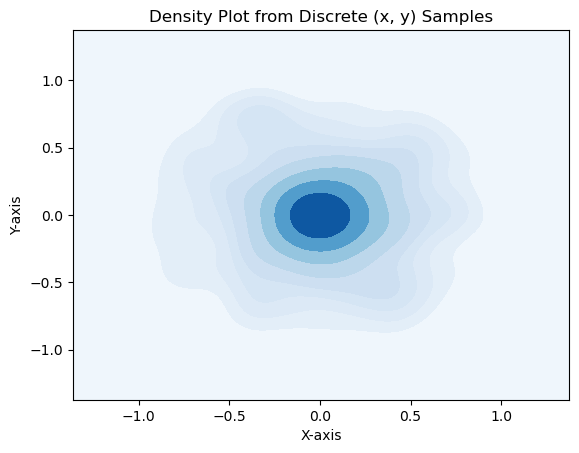

In [4]:
def sample_xy_naive():
    r = np.random.rand()
    phi = 2 * np.pi * np.random.rand()
    return r*np.cos(phi), r*np.sin(phi)

xplot = []
yplot = []
N = 1000
for i in range(N):
    x, y = sample_xy_naive()
    xplot.append(x)
    yplot.append(y)
    
plt.plot(xplot,yplot,'o',color='r')
plt.gca().set_aspect('equal')
plt.show()

# density plot
import seaborn as sns
sns.kdeplot(x=xplot, y=yplot, cmap="Blues", fill=True, thresh=0)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Density Plot from Discrete (x, y) Samples")
plt.show()

The points clump more in the centre! Why? Because $r$ is not uniformly distributed.
Recall

$$
dx dy = r dr d\phi,
$$

therefore

$$
\rho_r(r) = 2r, \qquad \rho_\phi(\phi) = \frac{1}{2\pi}.
$$

Cumulative distribution function

$$
F_r(r) = \int_0^r \rho_r(r') dr' = r^2.
$$

Solving $F_r(r) = \eta$ we get

$$
r = \sqrt{\eta}.
$$

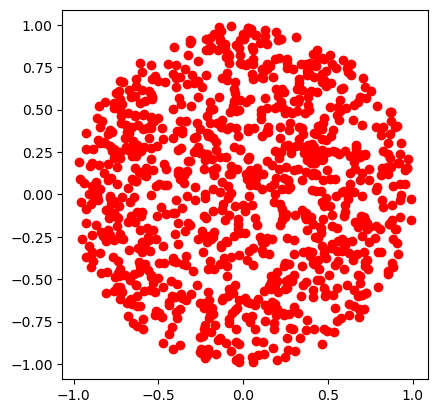

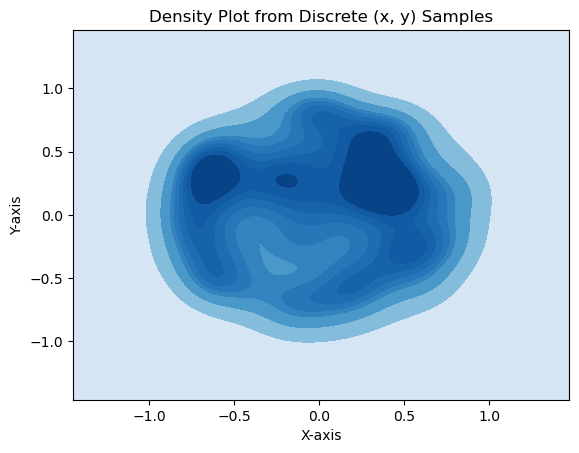

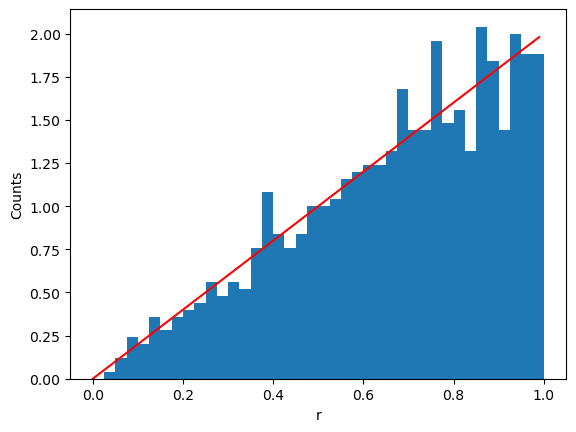

In [5]:
def sample_xy_correct():
    eta = np.random.rand()
    r = np.sqrt(eta)
    phi = 2 * np.pi * np.random.rand()
    return r*np.cos(phi), r*np.sin(phi)

xplot = []
yplot = []
rs = []
N = 1000
for i in range(N):
    x, y = sample_xy_correct()
    xplot.append(x)
    yplot.append(y)
    rs.append(np.sqrt(x*x+y*y))
    
plt.plot(xplot,yplot,'o',color='r')
plt.gca().set_aspect('equal')
plt.show()

# Show a density plot
import seaborn as sns
sns.kdeplot(x=xplot, y=yplot, cmap="Blues", fill=True, thresh=0)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Density Plot from Discrete (x, y) Samples")
plt.show()

# Show a histogram
plt.xlabel("r")
plt.ylabel("Counts")
plt.hist(rs, bins = 40, range=(0,1), density=True)
# Show true distribution
plt.plot([r for r in np.arange(0,1,0.01)], [2*r for r in np.arange(0,1,0.01)], color='r')
plt.show() 



### Sampling an isotropic direction

One common problem that occurs in Monte Carlo simulations is random sampling of an isotropic direction in 3D space.
For instance, this issue occurs when sampling a random orientation of some axially symmetric object (such as a rod) or the momentum of a particle.

This problem is equivalent to choosing a random point on a unit sphere. The coordinates $x,y,z$ on a unit sphere can be parametrized by azimuthal and polar angles, $\phi \in [0,2\pi)$ and $\theta \in [0,\pi]$:

\begin{align*}
x & = \sin(\theta) \cos(\phi),\\
y & = \sin(\theta) \sin(\phi),\\
z & = \cos(\theta).
\end{align*}

Recall that

$$
d\Omega = \sin(\theta) d \theta d\phi,
$$

thus the random variable $\phi$ and $\theta$ are independent.
$\phi$ is uniformly distributed in $[0,2\pi)$, thus, its sampling is straightforward.
However, the polar angle $\theta$ has a weighted probability density

$$
\rho_{\theta} (\theta) = \frac{1}{2} \sin(\theta),
$$

thus, its, distribution is non-uniform.
The cumulative distribution function reads

$$
F_{\theta}(\theta) = \int_0^\theta \frac{1}{2} \sin(\theta') d \theta' = \frac{1-\cos(\theta)}{2},
$$

thus

$$
\theta = \arccos(2\eta - 1).
$$

In practice, it can make sense to work directly with $\cos(\theta)$ and $\sin(\theta)$. Indeed, we have

$$
\cos(\theta) = 2 \eta - 1,
$$

and

$$
\sin(\theta) = \sqrt{1 - [\cos(\theta)]^2}
$$

This avoids the need to compute $\arccos$, which is a relativey expensive operation.

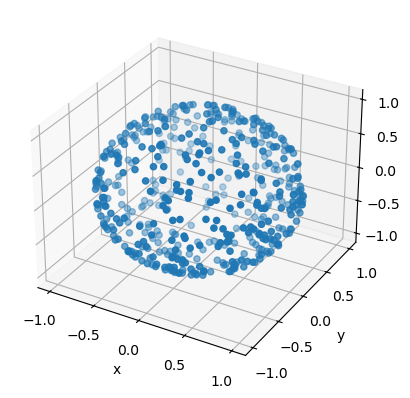

In [6]:
def sample_xyz_isotropic():
    phi = 2 * np.pi * np.random.rand()
    costh = 2 * np.random.rand() - 1
    sinth = np.sqrt(1-costh*costh)
    return sinth * np.cos(phi), sinth * np.sin(phi), costh

xplot = []
yplot = []
zplot = []
N = 500
for i in range(N):
    x, y, z = sample_xyz_isotropic()
    xplot.append(x)
    yplot.append(y)
    zplot.append(z)
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xplot,yplot,zplot)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Sampling the normal distribution

One of the most common distribution is the normal (or Gaussian) distribution

$$
\rho(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}.
$$

There are a lot of standard implementations of sampling this distribution. Let us go through one such method.
First, we can make a change of variable $x \to \mu + \sigma x$. The new variable then has a normal distribution with zero mean and standard deviation of unity

$$
\rho(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}.
$$

Calculating the cumulative distribution function $F(x) = \int_{-\infty}^x \rho(x)$ is not entirely trivial.

Instead of one variable, we can consider a pair of independent normally distributed variables $x,y$:

$$
\rho(x,y) = \frac{1}{2\pi} e^{-\frac{x^2}{2}} e^{-\frac{y^2}{2}},
$$

Making a change of variables to polar coordinates

$$
x = r \cos(\phi), \qquad y = r \sin(\phi),
$$

and taking into account

$$
dx dy = r dr d\phi
$$

we get

$$
\rho(r,\phi) = \frac{1}{2\pi} r e^{-r^2/2}.
$$

Therefore, we can sample $x$ and $y$ by sampling two independent random variables $r$ and $\phi$.
$\phi$ is uniformly distributed in $[0,2\pi)$.
For $r$ we have the following probability density

$$
\rho_r(r) = r e^{-r^2/2},
$$

and the cumulative distribution function

$$
F_r(r) = \int_0^r r' e^{-r'^2/2} dr' = 1 - e^{-r^2/2},
$$

therefore

$$
r = \sqrt{-2 \ln(1-\eta)}.
$$

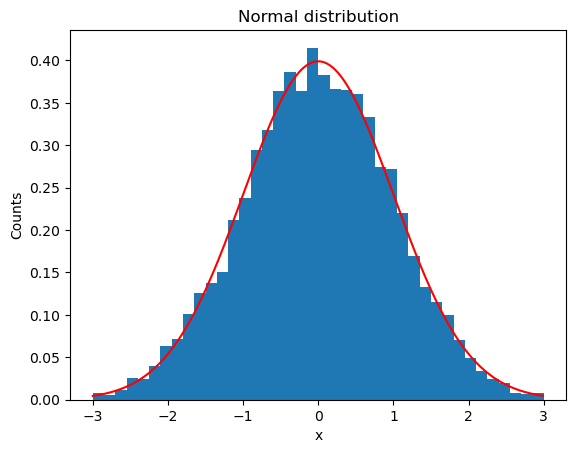

In [7]:
def sample_xy_normal():
    phi = 2 * np.pi * np.random.rand()
    eta = np.random.rand()
    r = np.sqrt(-2*np.log(1-eta))
    return r * np.cos(phi), r * np.sin(phi)

N = 10000
samples = []
for i in np.arange(0,N,2):
    x, y = sample_xy_normal()
    samples.append(x)
    samples.append(y)
    
# Show a histogram
plt.title("Normal distribution")
plt.xlabel("x")
plt.ylabel("Counts")
plt.hist(samples, bins = 40, range=(-3,3), density=True)
# Show true distribution
plt.plot([x for x in np.arange(-3,3,0.01)], [1/np.sqrt(2*np.pi)*np.exp(-x**2/2) for x in np.arange(-3,3,0.01)], color='r')
plt.show() 

## Rejection sampling

Rejection sampling is another common method for sampling non-uniform distributions.
In this method one samples a variable $\xi$ from an envelope distribution and accepts this value with a certain probability. 

Consider the distribution function for the polar angle again:

$$
\rho_\theta(\theta) = \frac{\sin(\theta)}{2}.
$$

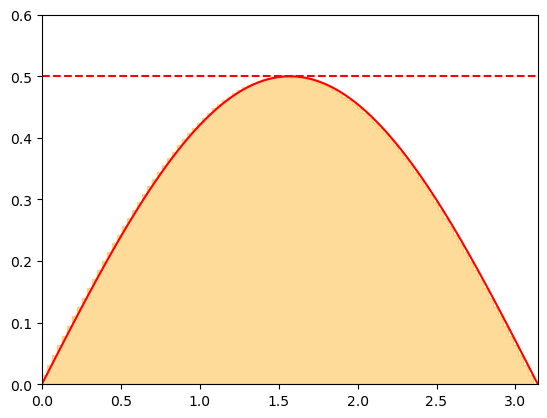

In [9]:
def rho_th(x):
    return np.sin(x) / 2

xplot = np.linspace(0,np.pi, 100)
yplot = rho_th(xplot)

plt.xlim(0,np.pi)
plt.ylim(0,0.6)
plt.plot(xplot, yplot,color='r')
plt.fill_between(xplot, yplot, step="pre", alpha = 0.4, color='orange')
plt.axhline(0.5,linestyle='--', color='r')
plt.show()

Note that $\rho_\theta$ is bounded from above $\rho_\theta < \rho_\theta^{\rm max} = 1/2$.
The rejection sampling method proceeds by
1. Sampling a candidate value $\theta_{\rm cand}$ from a uniform distribution over $(0,\pi)$.
2. Accepting the value $\theta_{\rm cand}$ with a probability $p = \rho_\theta(\theta_{\rm cand}) / \rho_\theta^{\rm max}$.

The second step can be performed by sampling $y$ as a uniform distribution over $(0,\rho_\theta^{\rm max})$ and accepting $\theta_{\rm cand}$ is $y < \rho_\theta(\theta_{\rm cand})$.

The procedure has simple geometrical interpretation. Considering $\theta_{\rm cand} \equiv x$ and $y$ to be the coordinates of a point on a plane, we accept $\theta_{\rm cand}$ for all points that lie below the curve given by the probability density $\rho_{\theta}(x)$. This ensures that the $\theta_{\rm cand}$ are accepted with a rate proprotional to $\rho_\theta(\theta)$, as desired.

One advantage of rejection sampling is that $\rho_\theta(\theta)$ need not be a normalized distribution for the method to work.

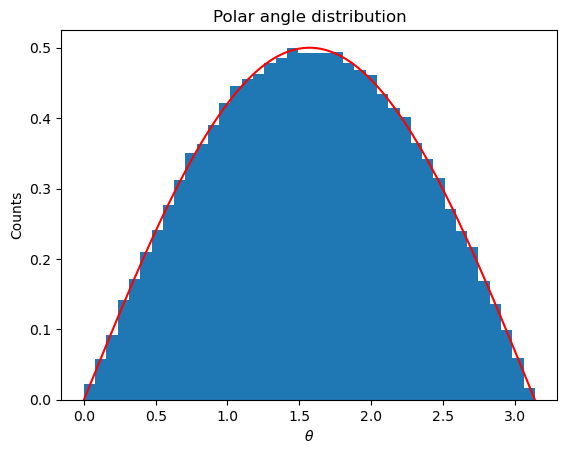

In [10]:
def sample_rejection(rho, a, b, rhomax):
    while True:
        x_cand = a + (b-a)*np.random.rand()
        y = rhomax * np.random.rand()
        if (y < rho(x_cand)):
            return x_cand
    return 0.

def rho_theta(theta):
    return np.sin(theta) / 2

N = 100000
samples = []
for i in np.arange(0,N,1):
    theta = sample_rejection(rho_theta, 0., np.pi, 1.5)
    samples.append(theta)
    
# Show a histogram
plt.title("Polar angle distribution")
plt.xlabel("${\\theta}$")
plt.ylabel("Counts")
plt.hist(samples, bins = 40, range=(0,np.pi), density=True)
# Show true distribution
plt.plot([x for x in np.arange(0,np.pi,0.01)], [rho_theta(x) for x in np.arange(0,np.pi,0.01)], color='r')
plt.show() 

### Advantages and disadvantages

Advantages:
- Does not need the distribution to be normalized
- Will also work if $y_{\rm max}$ is larger than the true maximum of $\rho(x)$, i.e. only the upper bound on the distribution maximum is needed
- Works for generic distributions and does not require the evaluation of cumulative distribution function

Disadvantages:
- Can be inefficient if the rejection rate is very high (highly peaked distribution)
- Not directly applicable to distributions over infinite ranges

### Generalizations of rejection sampling
Generalizations of rejection sampling can take care of some of the deficiencies. These include:
- Adaptive rejection sampling by considering several enveloping rectangles
- Variable transformation to map infinite interval into a finite one
- Sampling from a non-uniform enveloping distribution

## Importance sampling

Let us recall the calculation of integral as statistical average

$$
I = \int_a^b f(x) dx = (b - a) \langle f \rangle,
$$

where 

$$
\langle f \rangle = \frac{1}{N} \sum_{i=1}^N f(x_i),
$$

and $x_i$ are sampled from a uniform distribution over $(a,b)$, i.e.

$$
x_i \in U(a,b)
$$

In some cases, in particular, when $f(x)$ is highly peaked, only small part of the interval $(a,b)$ contributes to the total value of the integral. In this case sampling $x$ from $(a,b)$ with equal probability everywhere may be wasteful. Another issue may arise when $f(x)$ has integrable singularities. The method will still work, but the convergence rate for the statistical uncertainty can be slow.

An improvement can be obtained by applying the so-called **importance sampling** technique.
It is based on the following observation: Let $w(x)$ be the probability density for some random variable $x$.
We will assume $w(x)$ is normalized, i.e. 

$$
\int_a^b w(x) dx = 1.
$$

Then the mean value of an arbitrary random variable function $g(x)$ reads

$$
\langle g(x) \rangle_w = \int_a^b g(x) w(x) dx,
$$

where the subscript $w$ indicates that $x$ is distributed in accordance with probability density $w(x)$.

Let us return to our integral. Divinding and multiplying the integrand by $w(x)$ we can rewrite $I$ as

$$
I = \int_a^b \frac{f(x)}{w(x)} w(x) dx = \left\langle \frac{f(x)}{w(x)} \right\rangle_w~.
$$

The mean value $\frac{f(x)}{w(x)}$ is well-defined as long as $w(x) > 0$.
For $w(x) = \frac{1}{b-a}$ we reproduce the original method.

By choosing $w(x)$ to sample regions where the integrand $f(x)$ is most relevant, or to cancel away the integrable singularities one can significantly improve the statistical convergence of the method.


The error estimate is computed in essentially the same way as for the standard case

$$
\delta I = \frac{\sqrt{\left\langle \left[\frac{f(x)}{w(x)} \right]^2 \right\rangle_w - \left\langle \frac{f(x)}{w(x)} \right\rangle_w^2}}{\sqrt{N}}.
$$

Implementation of importance sampling in Python

In [11]:
# Calculate integral \int_a^b f(x) dx using importance sampling
# f = f(x) is the integrand
# N is the number of random samples
# wx = w(x) is the normalized probability density from which
# the sampling takes place
# sampler is a function which samples a random number from w(x)
def intMC_weighted(f, N, wx, sampler):
    total = 0
    total_sq = 0
    for i in range(N):
        x = sampler()
        fval = f(x)
        total += fval / wx(x)
        total_sq += (fval / wx(x))**2
    fw_av = total / N
    fwsq_av = total_sq / N 
    return fw_av, np.sqrt((fwsq_av - fw_av*fw_av)/N)

### Example
Let us consider integral

$$
\int_0^1 \frac{x^{-1/2}}{e^x + 1} dx
$$

which has an integrable singularity at $x = 0$.

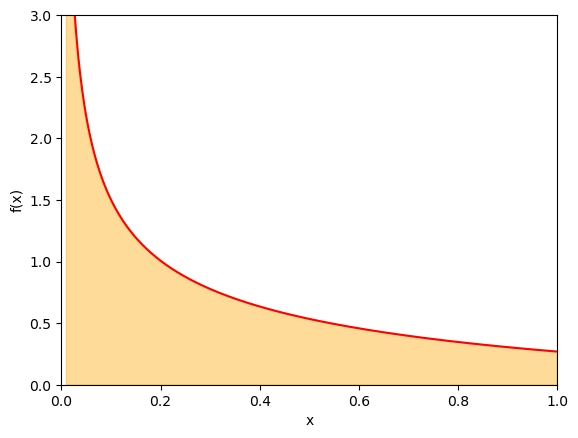

In [12]:
def f(x):
    return 1. / np.sqrt(x) / (np.exp(x) + 1)

xplot = np.linspace(0.01,1, 400)
yplot = f(xplot)

plt.xlim(0,1)
plt.ylim(0,3)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(xplot, yplot,color='r')
plt.fill_between(xplot, yplot, step="pre", alpha = 0.4, color='orange')
# plt.axhline(0.5,linestyle='--', color='r')
plt.show()

Let us first apply the standard mean value technique to estimate the integrand.
Let us take $N = 10^6$ samples

In [16]:
%%time

np.random.seed(1)
N = 1000000
I, err = intMC(f, N, 0, 1)
print("I = ",I," +- ",err)

I =  0.8374063441946126  +-  0.0017772180714415427
CPU times: user 1.18 s, sys: 23.4 ms, total: 1.21 s
Wall time: 1.21 s


We can check that using importance sampling routine with the weight $w(x) = \frac{1}{b-a}$ will reproduce the same result.

In [17]:
%%time

def uniform_sample():
    eta = np.random.rand()
    return eta

def uniform_w(x):
    return 1.

np.random.seed(1)
N = 1000000
I, err = intMC_weighted(f, N, uniform_w, uniform_sample)
print("I = ",I," +- ",err)

I =  0.8374063441946126  +-  0.0017772180714415427
CPU times: user 1.3 s, sys: 25.2 ms, total: 1.33 s
Wall time: 1.33 s


Although the method works, the convergence is rather slow. Can we improve upon it?

Let us choose the weight function such that it cancels out the singularity in the ratio $f(x)/w(x)$.
A natural choice here is

$$
w(x) = \frac{1}{2\sqrt{x}},
$$

such that $f(x)/w(x) = 2 / (e^x + 1)$ and thus

$$
I = \left\langle \frac{2}{e^x + 1} \right\rangle_w~.
$$

We can sample from $w(x)$ through the inverse transform method.
The cumulative distribution function reads

$$
G_w(x) = \int_0^x w(x) = \sqrt{x} = \eta,
$$

thus,

$$
x = \eta^2.
$$

We will be computing the average of

$$
\frac{f(x)}{w(x)} = \frac{2}{e^x + 1}
$$

which is a much smoother function than $f(x)$ over $(0,1)$.
In general, the smoother one can make $f(x)/w(x)$, the smaller statistical error of the calculation would be.

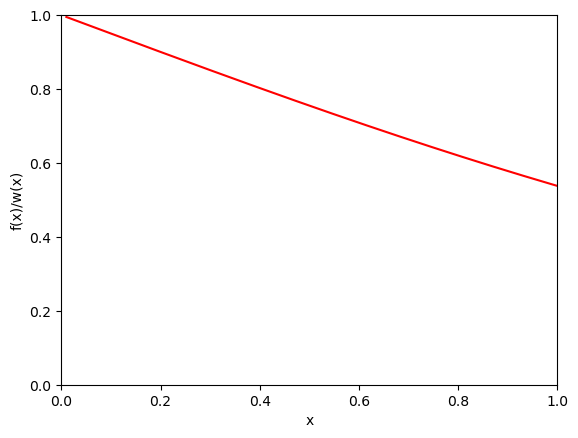

In [20]:
def rsqrt_sample():
    eta = np.random.rand()
    return eta * eta

def rsqrt_w(x):
    return 1. / (2. * np.sqrt(x))

xplot = np.linspace(0.01,1, 400)
yplot = [f(x) / rsqrt_w(x) for x in xplot]

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel("f(x)/w(x)")
plt.plot(xplot, yplot,color='r')
plt.show()

Let us calculate the integral with using importance sampling with the same number of samples.

In [21]:
%%time

N = 1000000
I, err = intMC_weighted(f, N, rsqrt_w, rsqrt_sample)
print("I = ",I," +- ",err)

I =  0.839014917136739  +-  0.0001409071521618816
CPU times: user 2.15 s, sys: 28.6 ms, total: 2.18 s
Wall time: 2.29 s


Notice that the statistical error is more than x10 smaller than the direct method.
We would need more than x100 samples in the direct method to reach the same accuracy as importance sampling in this case.